In [1]:
from main import *
from useful_functions import *
from visualization import *

%matplotlib inline
plt.rcParams['font.size'] = 6

# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

In [3]:
atlas = MapzebrainAtlas(atlas_path)
centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')

centroids_ = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)

# Loading figure-related data

In [4]:
FC = np.load('Results/FC_matrix.npy')
excluded = np.load('Results/excluded_regions.npy')

expression = np.load('Results/gene_expression.npy')
expression = np.delete(expression, excluded, axis=1)
expression = zscore(expression, axis=0) # Each region gets z-scored to account for spatial heterogeneity of signals (Z axis attenuation, etc)

coexpression = np.load('Results/figure7_coexpression_all.npy')
coexpression_null = np.load('Results/figure7_coexpression_all_null.npy')
coexpression_opt = np.load('Results/figure7_coexpression_optimized.npy')
coexpression_opt_null = np.load('Results/figure7_coexpression_optimized_null.npy')

scores = np.load('Results/figure7_scores_per_N.npy')
scores_null = np.load('Results/figure7_scores_per_N_null.npy')

projection_top = np.load('Results/figure7_optimal_genes_projection_top.npy')
projection_side = np.load('Results/figure7_optimal_genes_projection_side.npy')
colors_projection = np.load('Results/figure7_optimal_genes_colors.npy')

number_of_selections = np.load('Results/figure7_number_of_selections.npy') / 1000
number_of_selections_null = np.load('Results/figure7_number_of_selections_null.npy') / 1000

gene_names = np.load('Genes/gene_names.npy')

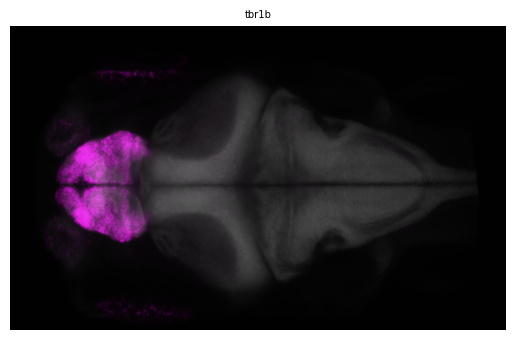

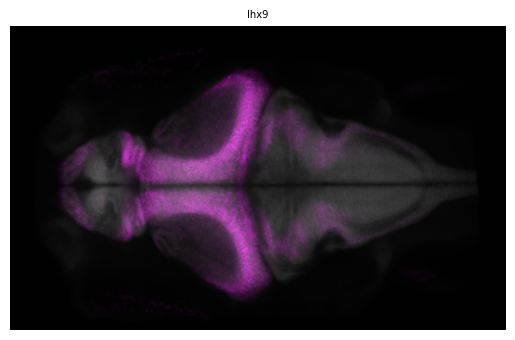

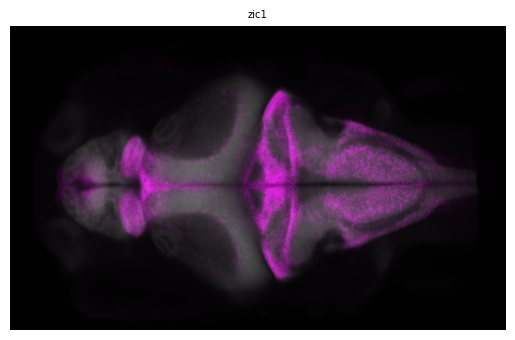

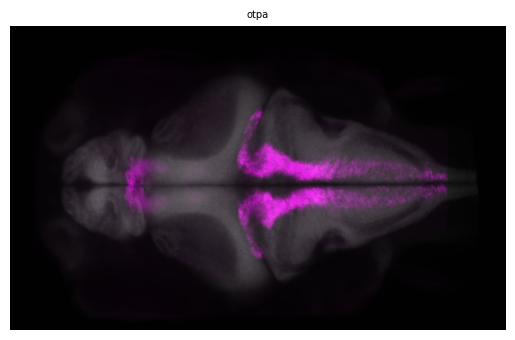

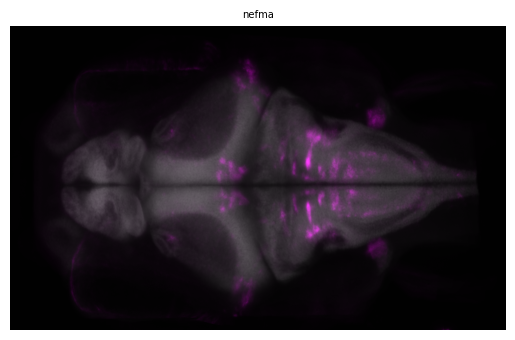

In [7]:
path = '/media/anleg84/Backup Plus/CERVO/Atlas/Mapzebrain/Gene expression/'
files = identify_files(path, ['.tif'])

projections_top = []
names = ['tbr1b', 'lhx9', 'zic1', 'otpa', 'nefma']
for name in names:
    for file in files:
        if name in file:
            stack = load_stack(path + file)
            projection_top = np.percentile(stack[::2, :, :], 95, axis=0)
            projections_top.append(projection_top)
            colors = [[0.5, 0.5, 0.5], [1, 0, 1]]
            im1 = merge([atlas.XYprojection, projection_top], colors)
            plt.imshow(np.rot90(im1))
            plt.axis('off')
            plt.title(name)
            plt.show()

In [8]:
selected_ids = []
for n in names:
    id = np.where(gene_names == n)[0][0]
    selected_ids.append(id)

# Figure layout

In [29]:
cmap = 'magma'

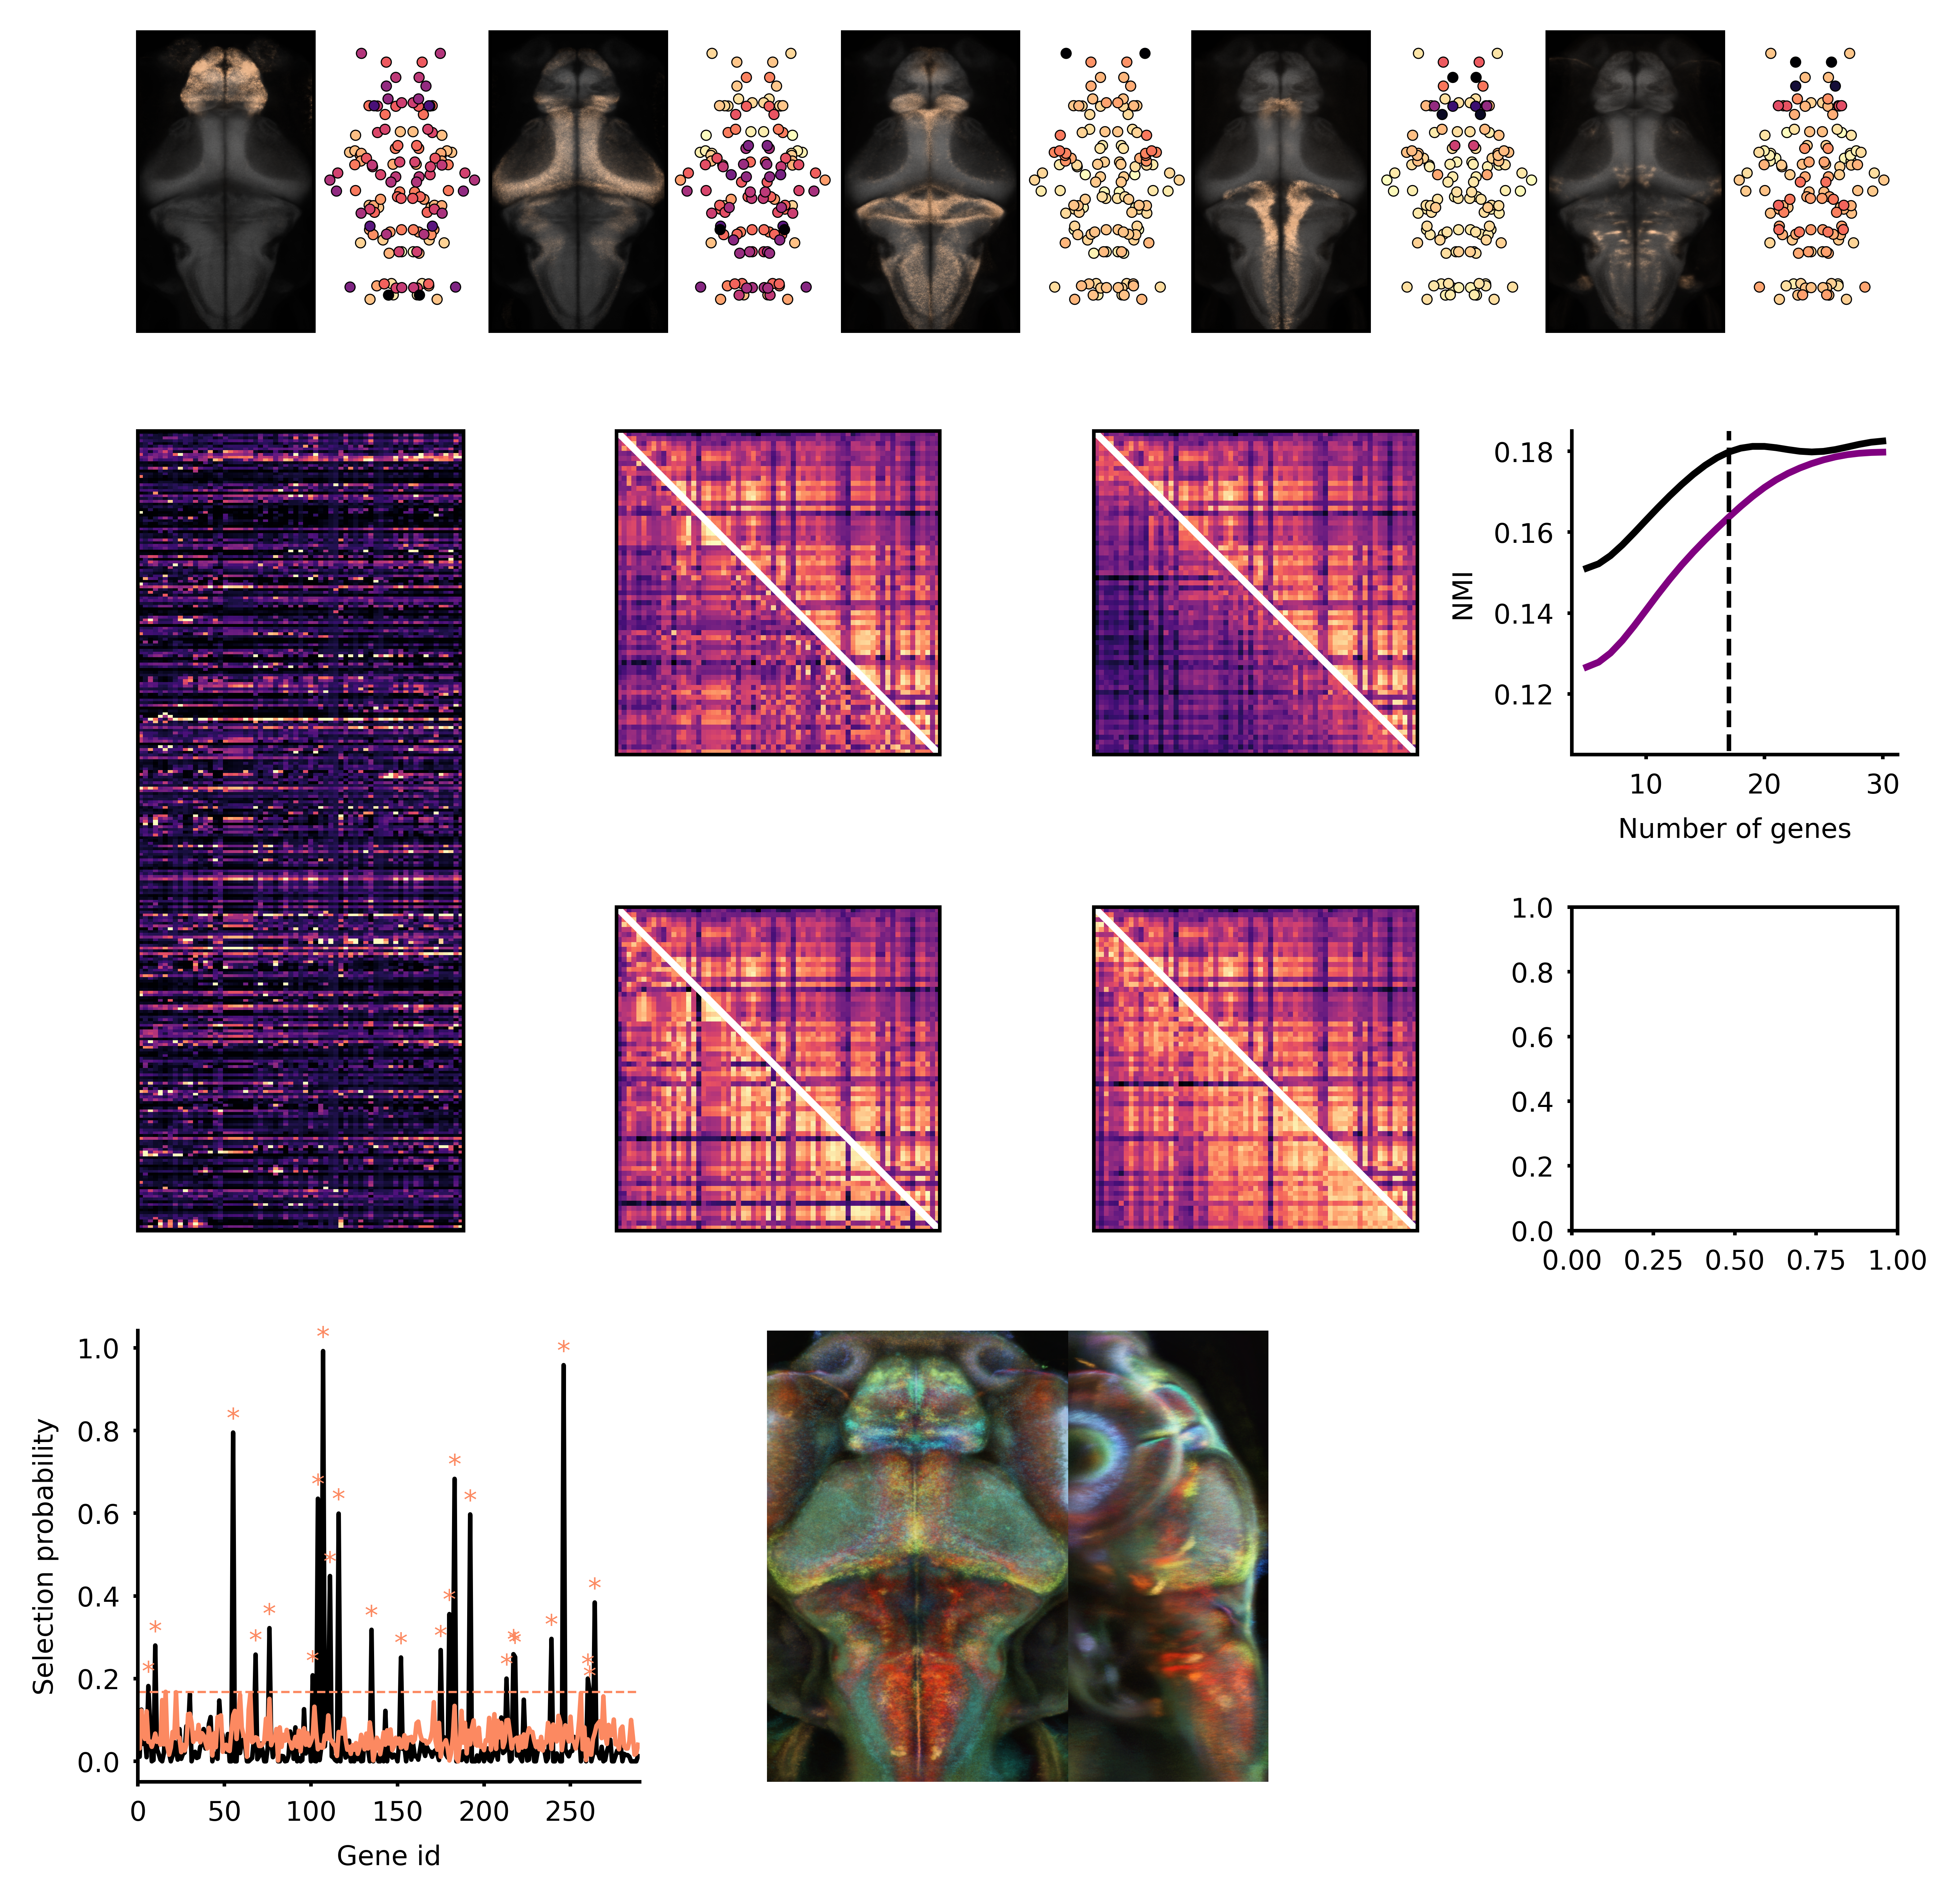

In [52]:
fig = PaperFigure(figsize=(7, 7), dpi=900)

fig.set_tick_length(1)
fig.set_font_size(6)
fig.add_background()

# Adding panels -------------------------------
x = 0.7
pad = (7 - 10 * x) / 4
h = 1.2
for i in range(5):
    fig.add_axes('gene{}'.format(i+1), (i * (2 * x + pad), 0), x, h)
    fig.add_axes('quantification{}'.format(i+1), (i * (2 * x + pad) + x, 0), x, h)
    fig.axes['gene{}'.format(i + 1)].set_xticks([])
    fig.axes['gene{}'.format(i + 1)].set_yticks([])
    fig.axes['quantification{}'.format(i + 1)].set_xticks([])
    fig.axes['quantification{}'.format(i + 1)].set_yticks([])

# Second row
y_2 = 1.6
size = 1.3
pad = (7 - 4 * size) / 3
fig.add_axes('expression', (0, y_2), size, 2 * size + pad)

fig.add_axes('coex', (size + pad, y_2), size, size)
fig.add_axes('coex_null', (2 * (size + pad), y_2), size, size)

fig.add_axes('coex_opt', (size + pad, y_2 + size + pad), size, size)
fig.add_axes('coex_opt_null', (2 * (size + pad), y_2 + size + pad), size, size)

fig.add_axes('elbow', (3 * (size + pad), y_2), size, size)
fig.add_axes('distributions', (3 * (size + pad), y_2 + size + pad), size, size)

y_3 = 5.2
size = 2
pad = (7 - 3 * size) / 2
ratio = 0.6
fig.add_axes('selections', (0, y_3), size, 2)

fig.add_axes('projection1', (size + pad, y_3), size * ratio, 2)

fig.add_axes('projection2', (size + pad + ratio * size, y_3), size * (1 - ratio), 2)


# Content -------------------------------------

for i in range(5):
    ax = fig.axes['gene{}'.format(i + 1)]
    colors = [[0.5, 0.5, 0.5], plt.get_cmap(cmap)(0.85)]
    im = merge([atlas.XYprojection, projections_top[i]], colors)
    ax.imshow(im,  aspect='auto')
    ax.set_xlim([65, 505])
    ax.set_ylim([850, 50])

    ax = fig.axes['quantification{}'.format(i + 1)]
    ax.imshow(atlas.XYprojection,  aspect='auto', cmap='gray', alpha=0)
    values = double(expression[selected_ids[i]])
    order = np.argsort(values)
    ax.scatter(centroids_[order, 0], centroids_[order, 1], c=values[order], cmap='magma_r',
               edgecolor='black', linewidth=0.25, s=5)
    ax.set_xlim([65, 505])
    ax.set_ylim([850, 50])
    ax.axis('off')

ax = fig.axes['expression']
ax.imshow(expression, cmap=cmap, vmin=np.percentile(expression, 10), vmax=np.percentile(expression, 99), aspect='auto')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['coex']
triangle = np.triu_indices(FC.shape[0], 1)
matrix = normalize(np.copy(coexpression))
matrix[triangle] = normalize(np.copy(FC))[triangle]
cax = ax.imshow(matrix, cmap=cmap)
ax.plot([0, 64.5], [0, 64.5], color='white', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['coex_null']
triangle = np.triu_indices(FC.shape[0], 1)
matrix = normalize(np.copy(coexpression_null))
matrix[triangle] = normalize(np.copy(FC))[triangle]
cax = ax.imshow(matrix, cmap=cmap)
ax.plot([0, 64.5], [0, 64.5], color='white', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['coex_opt']
triangle = np.triu_indices(FC.shape[0], 1)
matrix = normalize(np.copy(coexpression_opt))
matrix[triangle] = normalize(np.copy(FC))[triangle]
cax = ax.imshow(matrix, cmap=cmap)
ax.plot([0, 64.5], [0, 64.5], color='white', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['coex_opt_null']
triangle = np.triu_indices(FC.shape[0], 1)
matrix = normalize(np.copy(coexpression_opt_null))
matrix[triangle] = normalize(np.copy(FC))[triangle]
cax = ax.imshow(matrix, cmap=cmap)
ax.plot([0, 64.5], [0, 64.5], color='white', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['elbow']
ax.plot(np.arange(5, 31), gaussian_filter1d(scores, 3), color='black')
ax.plot(np.arange(5, 31), gaussian_filter1d(scores_null, 3), color='purple')
ax.plot([17, 17], [0.1, 0.2], color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Number of genes')
ax.set_ylabel('NMI')
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim([0.105, 0.185])

ax = fig.axes['selections']
ax.plot(number_of_selections, color='black', linewidth=1)
ax.plot(number_of_selections_null, color=plt.get_cmap(cmap)(0.75), linewidth=1, alpha=1)
threshold = np.max(number_of_selections_null)
ax.plot([0, expression.shape[0]], [threshold, threshold], color=plt.get_cmap(cmap)(0.75), linestyle='--', linewidth=0.5)
selected_ids = np.where((number_of_selections) > threshold)[0]
for i in selected_ids:
    ax.text(i, number_of_selections[i], '*', ha='center', va='bottom', color=plt.get_cmap(cmap)(0.75))
ax.set_ylabel('Selection probability')
ax.set_xlabel('Gene id')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim([0, expression.shape[0]])

ax = fig.axes['projection1']
ax.imshow(projection_top, aspect='auto')
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['projection2']
ax.imshow(np.rot90(projection_side, k=-1), aspect='auto')
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

# Display -------------------------------------

fig.show()

In [53]:
fig.save('/home/anleg84/Documents/Figures/PaperNetworks2024/figure7_incomplete.svg')

In [55]:
vector = np.zeros((len(colors_projection), 3))
for i, c in enumerate(colors_projection):
    vector[i] = c

In [56]:
vector = np.expand_dims(vector, axis=0)

In [58]:
%matplotlib inline

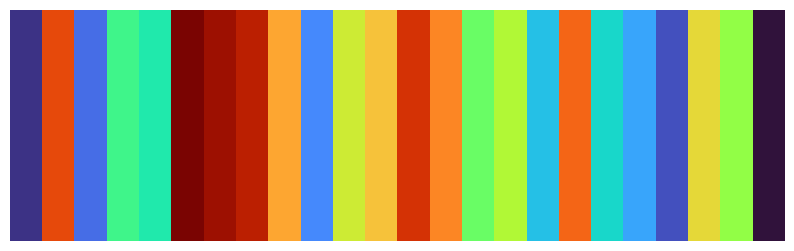

In [63]:
plt.figure(figsize=(10, 3))
plt.imshow(vector, aspect='auto')
plt.axis('off')
plt.savefig('/home/anleg84/Documents/Figures/PaperNetworks2024/figure7_color_vector.svg')

In [67]:
threshold = np.max(number_of_selections_null)
gene_names[np.where(number_of_selections > threshold)[0]]

array(['agrn', 'aldocb', 'crema', 'dlx2a', 'eomesa', 'glyt2', 'grik2',
       'hcn1', 'id2b', 'isl2b', 'mef2cb', 'nkx6.2', 'nxph1', 'onecut1',
       'opn7b', 'pax7a', 'pth2r', 'pyyb', 'r3hdm2', 'slc17a6b', 'sox1b',
       'tac1', 'tac3b', 'tbx2b'], dtype='<U16')